# Piece Difficulty Estimation

In this notebook we are going to explore predicting piece difficulty for piano pieces using "classical" machine learning techniques



In [1]:
import numpy as np
import partitura as pt
import os
import glob
import pandas as pd
import warnings
import pickle
import matplotlib.pyplot as plt

import sys

# Import classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

# For evaluation
from sklearn.metrics import accuracy_score, f1_score

from classification_utils import plot_confusion_matrix


# Increase the recursion limit
# This is necessary for pickling scores
sys.setrecursionlimit(100000)

warnings.filterwarnings("ignore", module="partitura")
warnings.filterwarnings("ignore", module="sklearn")

# Replace the with the path where you downloaded the data
PATH_TO_DATASET = "scores_difficulty_estimation"
PATH_TO_LABELS = "difficulty_classification_training.csv"

In [2]:
data = pd.read_csv(PATH_TO_LABELS)
data.head()

,file,difficulty
0,13.musicxml,1
1,80.musicxml,3
2,chopin_op28_No21.musicxml,6
3,beethoven_op014_no2_mv1.musicxml,6
4,beethoven_op079_mv3.musicxml,7


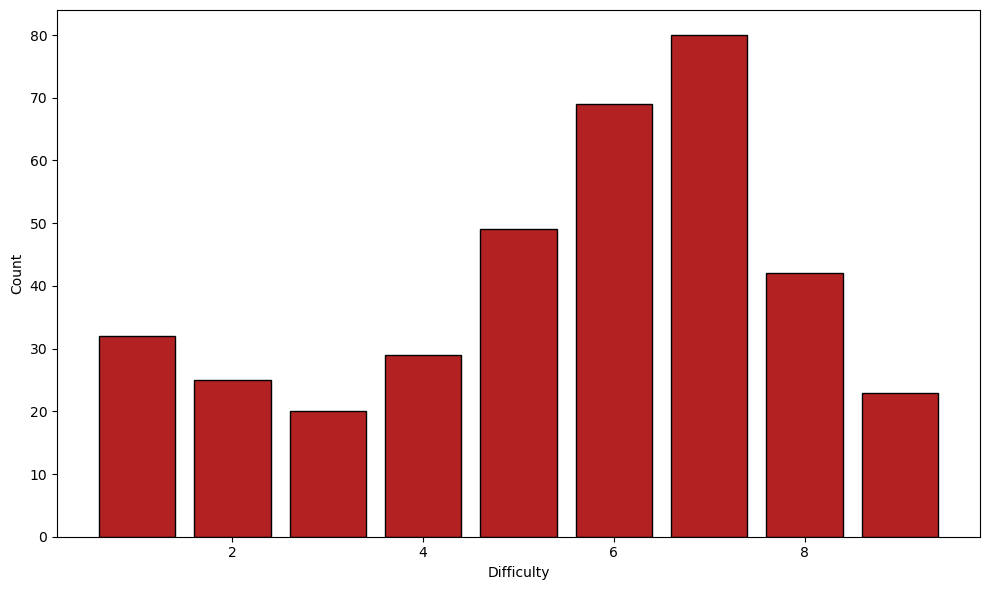

In [3]:
# Get the counts of each unique category
value_counts = data["difficulty"].value_counts()

# Plotting
plt.figure(figsize=(10, 6))


plt.bar(
    value_counts.index,
    value_counts.values,
    color="firebrick",
    edgecolor="black",
)
plt.xlabel("Difficulty")
plt.ylabel("Count")

# Show the plot
plt.tight_layout()
plt.show()

In [4]:
# Replace this path with the one where you downloaded the data
cached_scores_dir = "pickled_scores_difficulty_estimation"

if not os.path.exists(cached_scores_dir):
    os.mkdir(cached_scores_dir)

scores = []
score_names = []
difficulty = []
for i, (score_name, dif) in enumerate(zip(data["file"], data["difficulty"])):

    pickled_score_fn = os.path.join(cached_scores_dir, f"{score_name}.pyc")
    score_fn = os.path.join(PATH_TO_DATASET, score_name)

    if not os.path.exists(pickled_score_fn):
        score = pt.load_musicxml(score_fn)

        with open(pickled_score_fn, "wb") as f:
            print(f"saving {score_name}")
            pickle.dump(score, f)

    else:
        with open(pickled_score_fn, "rb") as f:
            score = pickle.load(f)

    scores.append(score)
    score_names.append(score_name)
    difficulty.append(dif)

In [5]:
for score in scores:
    score[0].use_musical_beat()
scores = np.array(scores, dtype=object)
score_names = np.array(score_names)
difficulty = np.array(difficulty)

extended_score_note_array = pt.utils.music.ensure_notearray(
    score,
    include_pitch_spelling=True,  # adds 3 fields: step, alter, octave
    include_key_signature=True,  # adds 2 fields: ks_fifths, ks_mode
    include_time_signature=True,  # adds 2 fields: ts_beats, ts_beat_type
    include_metrical_position=True,  # adds 3 fields: is_downbeat, rel_onset_div, tot_measure_div
    include_grace_notes=True,  # adds 2 fields: is_grace, grace_type
)

note_arrays = np.array(
    [
        pt.utils.music.ensure_notearray(
            score,
            include_pitch_spelling=True,  # adds 3 fields: step, alter, octave
            include_key_signature=True,  # adds 2 fields: ks_fifths, ks_mode
            include_time_signature=True,  # adds 2 fields: ts_beats, ts_beat_type
            include_metrical_position=True,  # adds 3 fields: is_downbeat, rel_onset_div, tot_measure_div
            include_grace_notes=True,  # adds 2 fields: is_grace, grace_type
        )
        for score in scores
    ],
    dtype=object,
)

In [6]:
# Split the dataset into training and testing sets with stratified sampling
from sklearn.model_selection import train_test_split


test_size = 0.2
na_train_val, na_test, di_train_val, di_test = train_test_split(
    note_arrays,
    difficulty,
    test_size=test_size,
    stratify=difficulty,
    random_state=42,
)

val_size = 0.1
na_train, na_val, di_train, di_val = train_test_split(
    na_train_val,
    di_train_val,
    test_size=val_size,
    stratify=di_train_val,
    random_state=1942,
)

# Print the shapes to verify
print(f"X_train shape: {na_train.shape}, Y_train shape: {di_train.shape}")
print(f"X_val shape: {na_val.shape}, Y_val shape: {di_val.shape}")
print(f"X_test shape: {na_test.shape}, Y_test shape: {di_test.shape}")

X_train shape: (265,), Y_train shape: (265,)
X_val shape: (30,), Y_val shape: (30,)
X_test shape: (74,), Y_test shape: (74,)


In [7]:
from typing import Union

from partitura.musicanalysis.note_features import list_note_feats_functions


note_feats_functions = list_note_feats_functions()

for nff in note_feats_functions:
    print(nff)


def compute_note_density(score: Union[pt.score.ScoreLike, np.ndarray]) -> float:

    if isinstance(score, (pt.score.Score, pt.score.Part)):

        note_array = score.note_array()
    elif isinstance(score, np.ndarray):
        note_array = score

    piece_duration_beats = (
        note_array["onset_beat"] + note_array["duration_beat"]
    ).max() - note_array["onset_beat"].min()

    number_of_notes = len(note_array)

    note_density = number_of_notes / piece_duration_beats

    return note_density


def compute_piece_length(score: Union[pt.score.ScoreLike, np.ndarray]) -> float:

    if isinstance(score, (pt.score.Score, pt.score.Part)):

        note_array = score.note_array()
    elif isinstance(score, np.ndarray):
        note_array = score

    piece_duration_beats = (
        note_array["onset_beat"] + note_array["duration_beat"]
    ).max() - note_array["onset_beat"].min()

    return piece_duration_beats

articulation_direction_feature
articulation_feature
clef_feature
duration_feature
fermata_feature
grace_feature
loudness_direction_feature
metrical_feature
metrical_strength_feature
onset_feature
ornament_feature
polynomial_pitch_feature
relative_score_position_feature
slur_feature
staff_feature
tempo_direction_feature
time_signature_feature
vertical_neighbor_feature


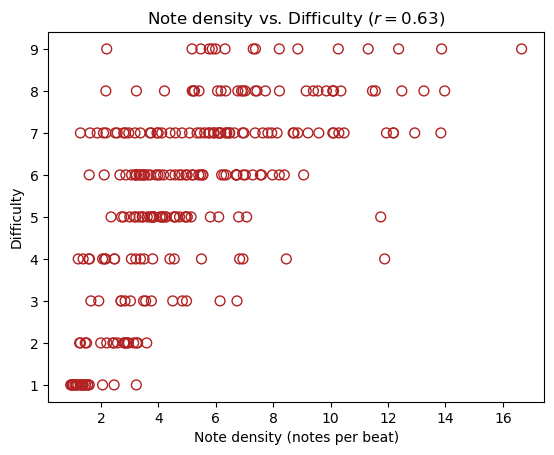

In [8]:
import matplotlib.pyplot as plt

note_densities = np.array([compute_note_density(na) for na in na_train])

plt.scatter(
    note_densities,
    di_train,
    s=50,  # Marker size
    facecolors="none",  # Unfilled markers
    edgecolors="firebrick",  # Marker edge color
    marker="o",
)

duration_corr = np.corrcoef(note_densities, di_train)[0, 1]
plt.title(f"Note density vs. Difficulty ($r = {duration_corr:0.2f}$)")
plt.xlabel("Note density (notes per beat)")
plt.ylabel("Difficulty")
plt.show()

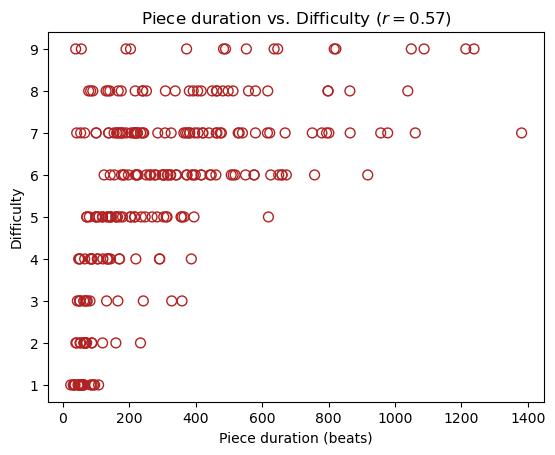

In [9]:
piece_duration = np.array([compute_piece_length(na) for na in na_train])

plt.scatter(
    piece_duration,
    di_train,
    s=50,  # Marker size
    facecolors="none",  # Unfilled markers
    edgecolors="firebrick",  # Marker edge color
    marker="o",
)
duration_corr = np.corrcoef(piece_duration, di_train)[0, 1]
plt.xlabel("Piece duration (beats)")
plt.ylabel("Difficulty")
plt.title(f"Piece duration vs. Difficulty ($r = {duration_corr:0.2f}$)")
plt.show()

In [10]:
from partitura.musicanalysis.note_features import vertical_neighbor_feature


def compute_vertical_neighbors(
    score: Union[pt.score.ScoreLike, np.ndarray]
) -> np.ndarray:
    """Vertical neighbor feature.

    Describes various aspects of simultaneously starting notes.

    Returns:
    * n_total :
    * n_above :
    * n_below :
    * highest_pitch :
    * lowest_pitch :
    * pitch_range :

    """

    if isinstance(score, (pt.score.Score, pt.score.Part)):

        na = score.note_array()
    elif isinstance(score, np.ndarray):
        na = score
    # the list of descriptors
    names = [
        "n_total",
        "n_above",
        "n_below",
        "highest_pitch",
        "lowest_pitch",
        "pitch_range",
    ]
    W = np.zeros((len(na), len(names)))
    for i, n in enumerate(na):
        neighbors = na[np.where(na["onset_beat"] == n["onset_beat"])]["pitch"]
        max_pitch = np.max(neighbors)
        min_pitch = np.min(neighbors)
        W[i, 0] = len(neighbors) - 1
        W[i, 1] = np.sum(neighbors > n["pitch"])
        W[i, 2] = np.sum(neighbors < n["pitch"])
        W[i, 3] = max_pitch
        W[i, 4] = min_pitch
        W[i, 5] = max_pitch - min_pitch

    vertical_neighbors = W.mean(0)
    return vertical_neighbors


vertical_neighbors = np.array([compute_vertical_neighbors(na) for na in na_train])

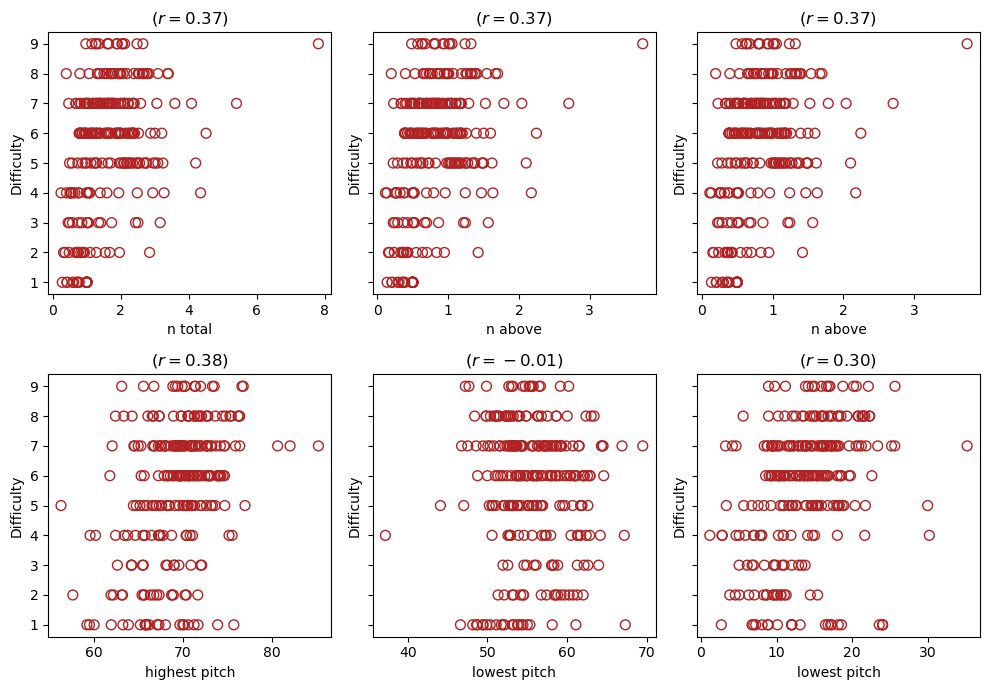

In [11]:
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(10, 7))

axes[0, 0].scatter(
    vertical_neighbors[:, 0],
    di_train,
    s=50,  # Marker size
    facecolors="none",  # Unfilled markers
    edgecolors="firebrick",  # Marker edge color
    marker="o",
)
axes[0, 0].set_xlabel("n total")
total_neighbors_corr = np.corrcoef(vertical_neighbors[:, 0], di_train)[0, 1]
axes[0, 0].set_ylabel("Difficulty")
axes[0, 0].set_title(f"($r = {total_neighbors_corr:0.2f}$)")


axes[0, 1].scatter(
    vertical_neighbors[:, 1],
    di_train,
    s=50,  # Marker size
    facecolors="none",  # Unfilled markers
    edgecolors="firebrick",  # Marker edge color
    marker="o",
)
axes[0, 1].set_xlabel("n above")
above_neighbors_corr = np.corrcoef(vertical_neighbors[:, 1], di_train)[0, 1]
axes[0, 1].set_ylabel("Difficulty")
axes[0, 1].set_title(f"($r = {above_neighbors_corr:0.2f}$)")


axes[0, 2].scatter(
    vertical_neighbors[:, 2],
    di_train,
    s=50,  # Marker size
    facecolors="none",  # Unfilled markers
    edgecolors="firebrick",  # Marker edge color
    marker="o",
)
axes[0, 2].set_xlabel("n above")
above_neighbors_corr = np.corrcoef(vertical_neighbors[:, 2], di_train)[0, 1]
axes[0, 2].set_ylabel("Difficulty")
axes[0, 2].set_title(f"($r = {above_neighbors_corr:0.2f}$)")

axes[1, 0].scatter(
    vertical_neighbors[:, 3],
    di_train,
    s=50,  # Marker size
    facecolors="none",  # Unfilled markers
    edgecolors="firebrick",  # Marker edge color
    marker="o",
)
axes[1, 0].set_xlabel("highest pitch")
above_neighbors_corr = np.corrcoef(vertical_neighbors[:, 3], di_train)[0, 1]
axes[1, 0].set_ylabel("Difficulty")
axes[1, 0].set_title(f"($r = {above_neighbors_corr:0.2f}$)")

axes[1, 1].scatter(
    vertical_neighbors[:, 4],
    di_train,
    s=50,  # Marker size
    facecolors="none",  # Unfilled markers
    edgecolors="firebrick",  # Marker edge color
    marker="o",
)
axes[1, 1].set_xlabel("lowest pitch")
above_neighbors_corr = np.corrcoef(vertical_neighbors[:, 4], di_train)[0, 1]
axes[1, 1].set_ylabel("Difficulty")
axes[1, 1].set_title(f"($r = {above_neighbors_corr:0.2f}$)")

axes[1, 2].scatter(
    vertical_neighbors[:, 5],
    di_train,
    s=50,  # Marker size
    facecolors="none",  # Unfilled markers
    edgecolors="firebrick",  # Marker edge color
    marker="o",
)
axes[1, 2].set_xlabel("lowest pitch")
above_neighbors_corr = np.corrcoef(vertical_neighbors[:, 5], di_train)[0, 1]
axes[1, 2].set_ylabel("Difficulty")
axes[1, 2].set_title(f"($r = {above_neighbors_corr:0.2f}$)")


plt.tight_layout()

In [12]:
def compute_score_features(
    score: Union[pt.score.Score, pt.score.Part, np.ndarray]
) -> np.ndarray:

    if isinstance(score, (pt.score.Score, pt.score.Part)):

        na = score.note_array()
    elif isinstance(score, np.ndarray):
        na = score

    ## TODO: Compute all features here
    # Decide which features might be more relevant

    note_density = compute_note_density(na)
    piece_duration = compute_piece_length(na)
    vertical_neighbors = compute_vertical_neighbors(na)

    features = np.r_[note_density, piece_duration, vertical_neighbors]

    return features

In [13]:
# If we are not using a method with hyperparameters, we can use the entire training set.
# otherwise
# X_train = np.array([compute_score_features(na) for na in na_train])
X_train = np.array([compute_score_features(na) for na in na_train_val])
# if we need validation
# X_val = np.array([compute_score_features(na) for na in na_val])

X_test = np.array([compute_score_features(na) for na in na_test])

Y_train = di_train_val
Y_test = di_test

In [14]:
classifiers = {
    "Baseline": DummyClassifier(strategy='most_frequent'),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000),
}

Training Baseline classifier.


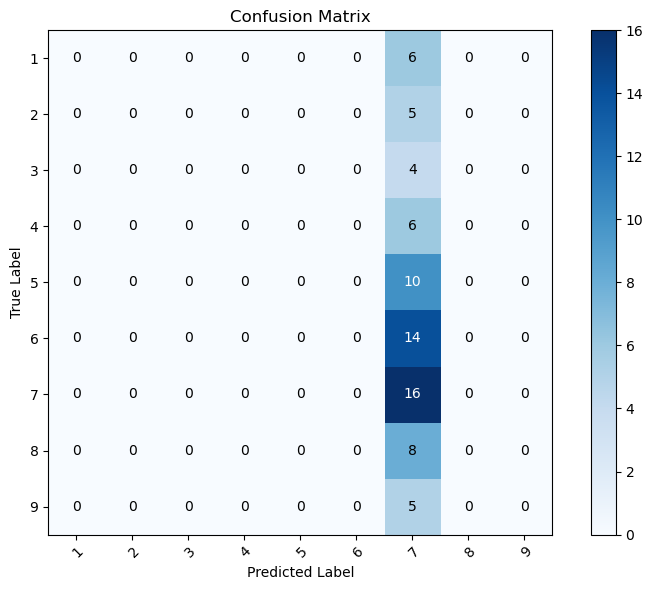

Accuracy of Baseline: 0.22
Macro F1-score Baseline: 0.04
Training Naive Bayes classifier.


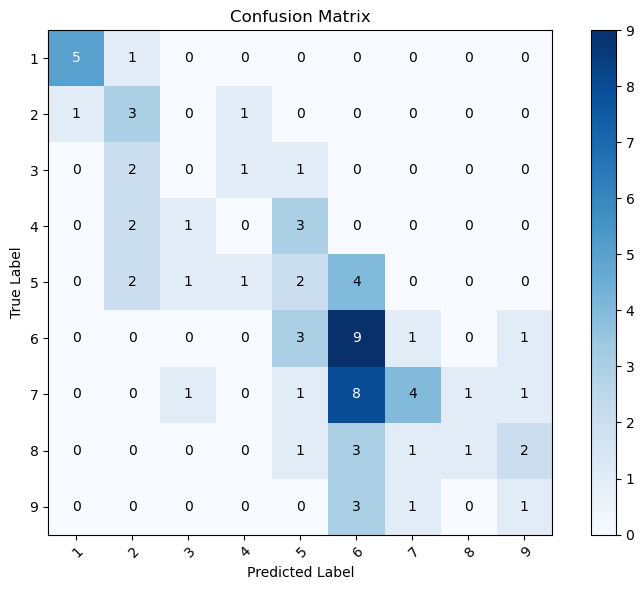

Accuracy of Naive Bayes: 0.34
Macro F1-score Naive Bayes: 0.29
Training Decision Tree classifier.


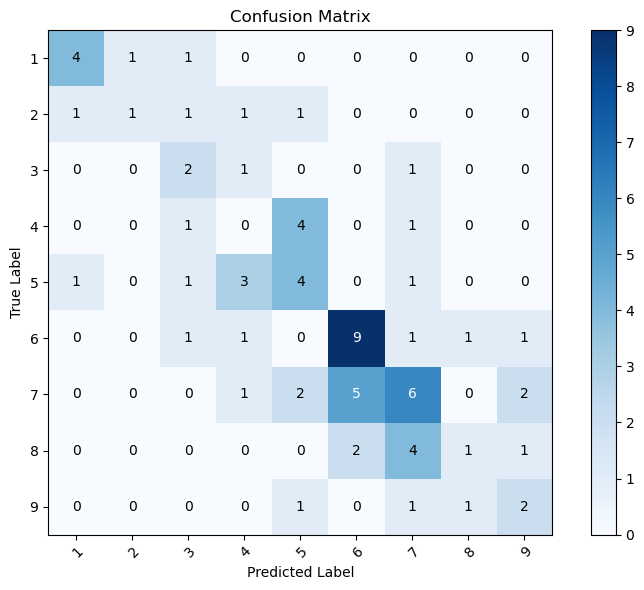

Accuracy of Decision Tree: 0.39
Macro F1-score Decision Tree: 0.36
Training Support Vector Machine classifier.


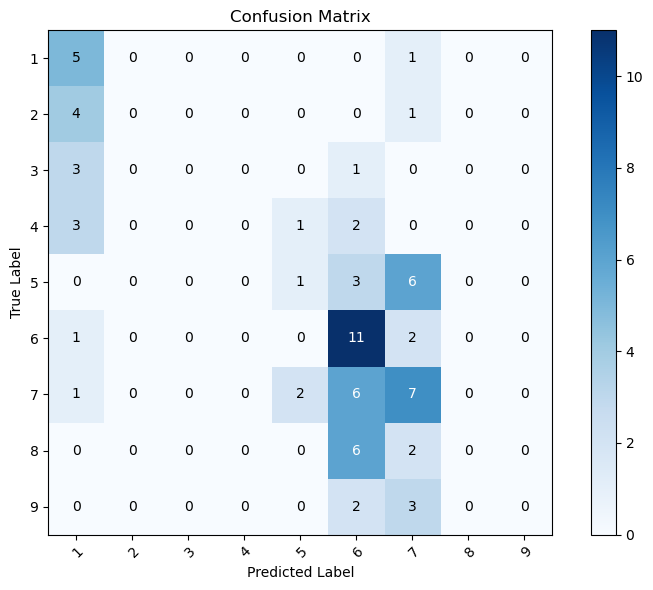

Accuracy of Support Vector Machine: 0.32
Macro F1-score Support Vector Machine: 0.16
Training K-Nearest Neighbors classifier.


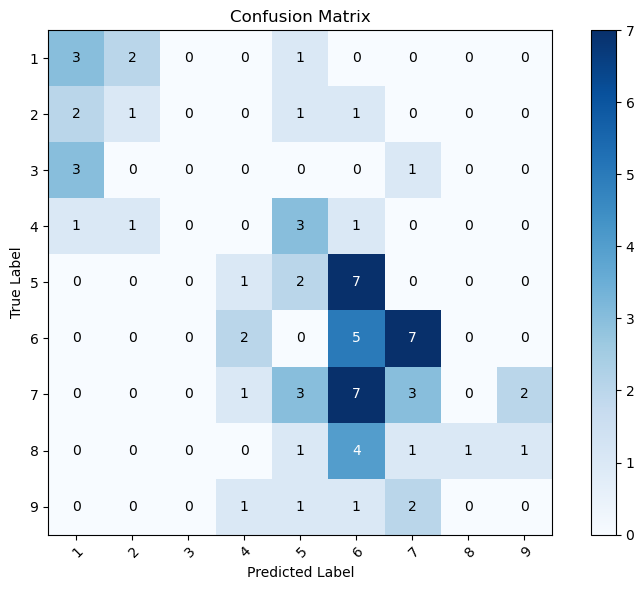

Accuracy of K-Nearest Neighbors: 0.20
Macro F1-score K-Nearest Neighbors: 0.16
Training Logistic Regression classifier.


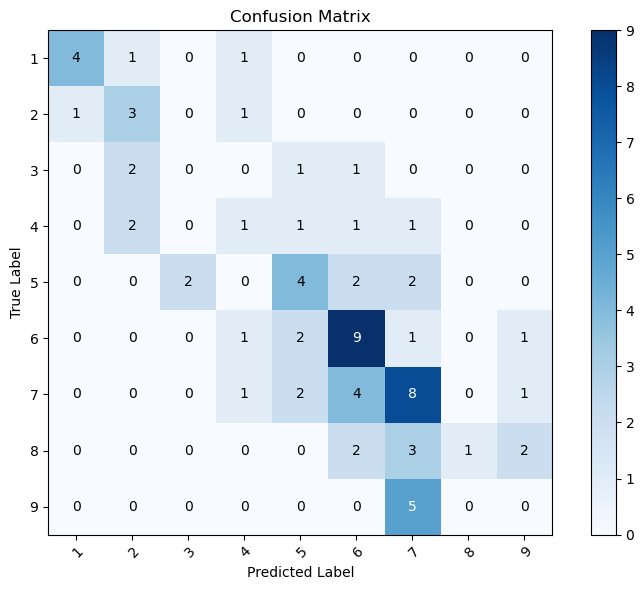

Accuracy of Logistic Regression: 0.41
Macro F1-score Logistic Regression: 0.33
Training Random Forest classifier.


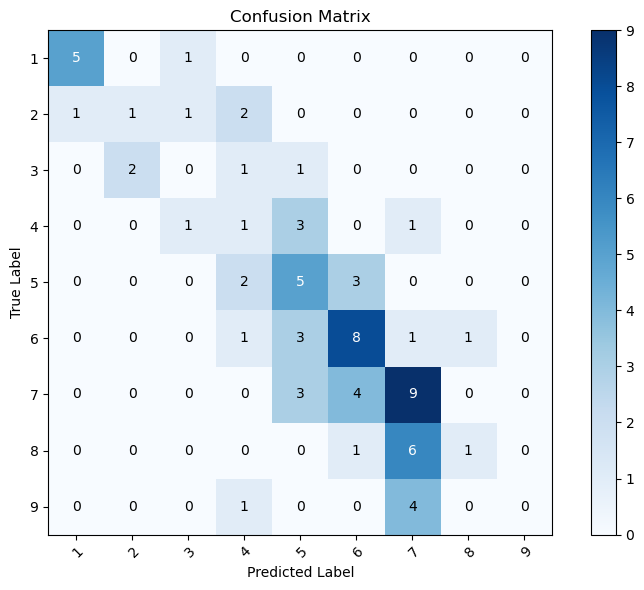

Accuracy of Random Forest: 0.41
Macro F1-score Random Forest: 0.32
Training Neural Network classifier.


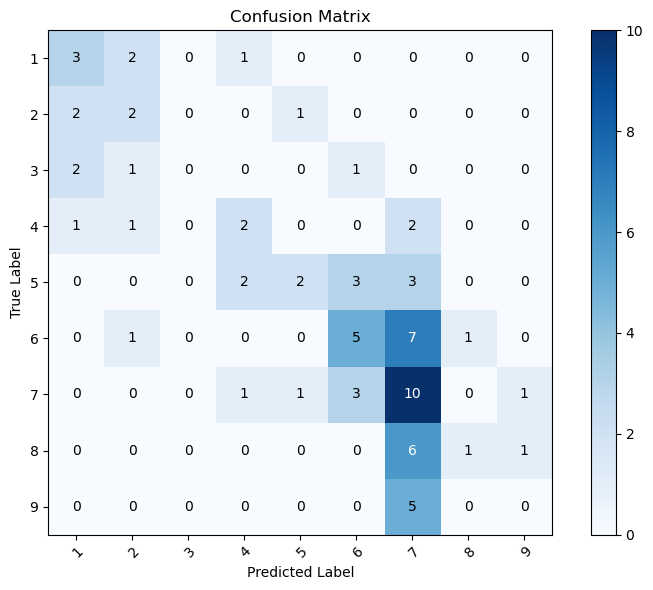

Accuracy of Neural Network: 0.34
Macro F1-score Neural Network: 0.26


: 

In [ ]:
for name, clf in classifiers.items():
    print(f"Training {name} classifier.")
    # Train the classifier
    clf.fit(X_train, Y_train)
    # Predict on test set
    Y_pred = clf.predict(X_test)
    # Evaluate the classifier
    acc = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average="macro")
    plot_confusion_matrix(predictions=Y_pred, targets=Y_test, class_names=[f"{i}" for i in range(1, 10)])
    print(f"Accuracy of {name}: {acc:.2f}")
    print(f"Macro F1-score {name}: {f1:.2f}")